# **Predicting Annual Medical Insurance Costs - ANN**
Authors: Christian Bammann, Ryan Monroe

December 2025

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.utils.data
from sklearn import metrics

### **Dataset**

In [ ]:
from IPython.display import display

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/insurance.csv')
df['charges'] = np.log(df['charges'])
df = pd.get_dummies(df, drop_first=True)

X = df.drop('charges', axis=1).values
Y = df['charges'].values

print("Features (X) shape:", X.shape)
print("Target (Y) shape:", Y.shape)
print("First 5 rows of X:")

display(df)

Features (X) shape: (1338, 8)
Target (Y) shape: (1338,)
First 5 rows of X:


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,9.734176,False,True,False,False,True
1,18,33.770,1,7.453302,True,False,False,True,False
2,28,33.000,3,8.400538,True,False,False,True,False
3,33,22.705,0,9.998092,True,False,True,False,False
4,32,28.880,0,8.260197,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,9.268661,True,False,True,False,False
1334,18,31.920,0,7.698927,False,False,False,False,False
1335,18,36.850,0,7.396233,False,False,False,True,False
1336,21,25.800,0,7.604867,False,False,False,False,True


### **Training**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_scaled, dtype=torch.float32)

Y_train_scaled = Y_train
Y_val_scaled   = Y_val

Y_train_scaled_tensor = torch.tensor(Y_train_scaled, dtype=torch.float32).view(-1,1)
Y_val_scaled_tensor   = torch.tensor(Y_val_scaled, dtype=torch.float32).view(-1,1)

In [ ]:
X_train_tensor = torch.from_numpy(X_train_scaled).float()
Y_train_tensor = torch.from_numpy(Y_train_scaled).float().unsqueeze(1)

X_val_tensor = torch.from_numpy(X_val_scaled).float()
Y_val_tensor = torch.from_numpy(Y_val_scaled).float().unsqueeze(1)

### **Artifical Neural Network (ANN)**

In [ ]:
hidden_size   = 2**5
linear_size   = 2**4
hidden_size_2 = 2**3

class Net(nn.Module):
    def __init__(self, n_input_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_input_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.fc4(x)
        return x

### **ANN Training**

In [ ]:
num_epochs = 200
learning_rate = 0.01

loss_fn = nn.MSELoss()

In [ ]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_scaled_tensor)
val_dataset   = torch.utils.data.TensorDataset(X_val_tensor, Y_val_scaled_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

n_input_features = X_train_tensor.shape[1]
model_nn = Net(n_input_features)

optimizer = torch.optim.Adam(model_nn.parameters(), lr=0.005)

print(f"Model initialized with {n_input_features} input features.")

def training_loop_with_val(n_epochs, optimizer, model_nn, loss_fn, train_loader, val_loader):
  train_losses = []
  val_losses = []

  for epoch in range(1, n_epochs + 1):

    model_nn.train()
    current_epoch_train_loss = 0.0
    for imgs, labels in train_loader:
      outputs = model_nn(imgs)
      batch_loss = loss_fn(outputs, labels)
      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()
      current_epoch_train_loss += batch_loss.item()

    avg_epoch_train_loss = current_epoch_train_loss / len(train_loader)
    train_losses.append(avg_epoch_train_loss)


    model_nn.eval()
    current_epoch_val_loss = 0.0
    with torch.no_grad():
      for imgs, labels in val_loader:
        outputs = model_nn(imgs)
        batch_loss = loss_fn(outputs, labels)
        current_epoch_val_loss += batch_loss.item()

    avg_epoch_val_loss = current_epoch_val_loss / len(val_loader)
    val_losses.append(avg_epoch_val_loss)

    if epoch <= 0 or epoch % 100 == 0:
      print(f"Epoch {epoch}, Training loss: {avg_epoch_train_loss:.4f}, Validation loss: {avg_epoch_val_loss:.4f}")
  return model_nn, train_losses, val_losses

Model initialized with 8 input features.


In [ ]:
model_nn, train_losses, val_losses = training_loop_with_val(
    n_epochs = num_epochs,
    optimizer = optimizer,
    model_nn = model_nn,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader)

Epoch 100, Training loss: 0.1290, Validation loss: 0.1306
Epoch 200, Training loss: 0.1186, Validation loss: 0.1312


###**Model Evaluation**





In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model_nn.eval()

with torch.no_grad():
    val_Y_pred_scaled = model_nn(X_val_tensor).squeeze()

val_Y_pred = val_Y_pred_scaled
val_Y_true = Y_val_scaled_tensor.squeeze()

mse = mean_squared_error(val_Y_true, val_Y_pred)
mae = mean_absolute_error(val_Y_true, val_Y_pred)
r2 = r2_score(val_Y_true, val_Y_pred)

print("ANN Regression Evaluation:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")

ANN Regression Evaluation:
MSE: 0.1502
MAE: 0.2177
R²:  0.8330


### **Visualization**

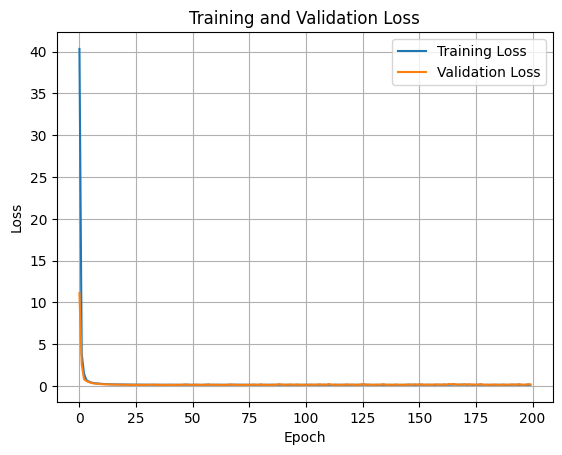

NameError: name 'val_Y_true_unscaled_retrained' is not defined

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Convert tensors to numpy arrays for plotting
val_Y_true_unscaled_retrained_np = val_Y_true_unscaled_retrained.cpu().numpy()
val_Y_pred_unscaled_retrained_np = val_Y_pred_unscaled_retrained.cpu().numpy()

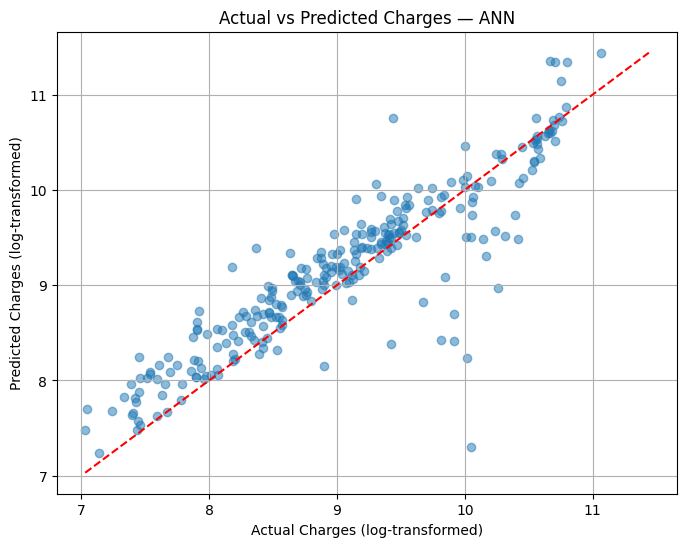

In [ ]:
val_Y_true_np = val_Y_true.cpu().numpy()
val_Y_pred_np = val_Y_pred.cpu().numpy()

plt.figure(figsize=(8,6))
plt.scatter(val_Y_true_np, val_Y_pred_np, alpha=0.5)

min_val = min(val_Y_true_np.min(), val_Y_pred_np.min())
max_val = max(val_Y_true_np.max(), val_Y_pred_np.max())

plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.xlabel('Actual Charges (log-transformed)')
plt.ylabel('Predicted Charges (log-transformed)')
plt.title('Actual vs Predicted Charges — ANN')
plt.grid(True)
plt.show()

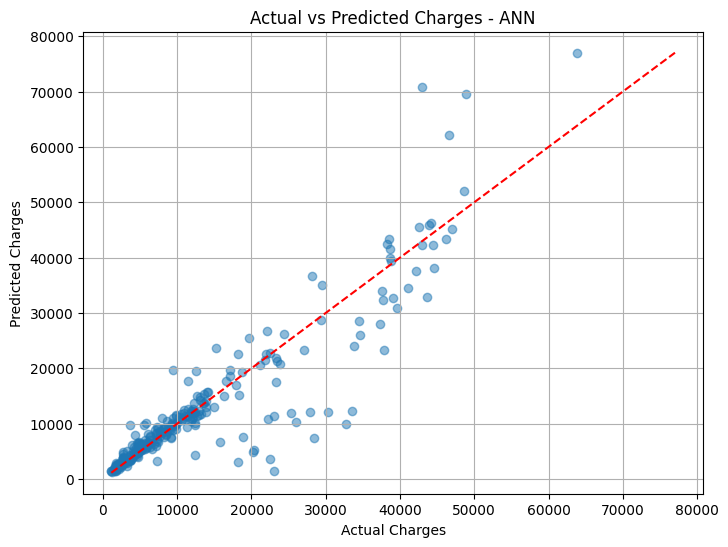

In [ ]:
val_Y_true_np = val_Y_true.cpu().numpy()
val_Y_pred_np = val_Y_pred.cpu().numpy()

actual_dollars = np.exp(val_Y_true_np)
predicted_dollars = np.exp(val_Y_pred_np)

plt.figure(figsize=(8,6))
plt.scatter(actual_dollars, predicted_dollars, alpha=0.5)

min_val = min(actual_dollars.min(), predicted_dollars.min())
max_val = max(actual_dollars.max(), predicted_dollars.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges - ANN')
plt.grid(True)
plt.show()

### **Feature Visualization**

In [ ]:
features = ['age', 'bmi', 'children', 'sex_male', 'smoker_yes',
            'region_northwest', 'region_southeast', 'region_southwest']

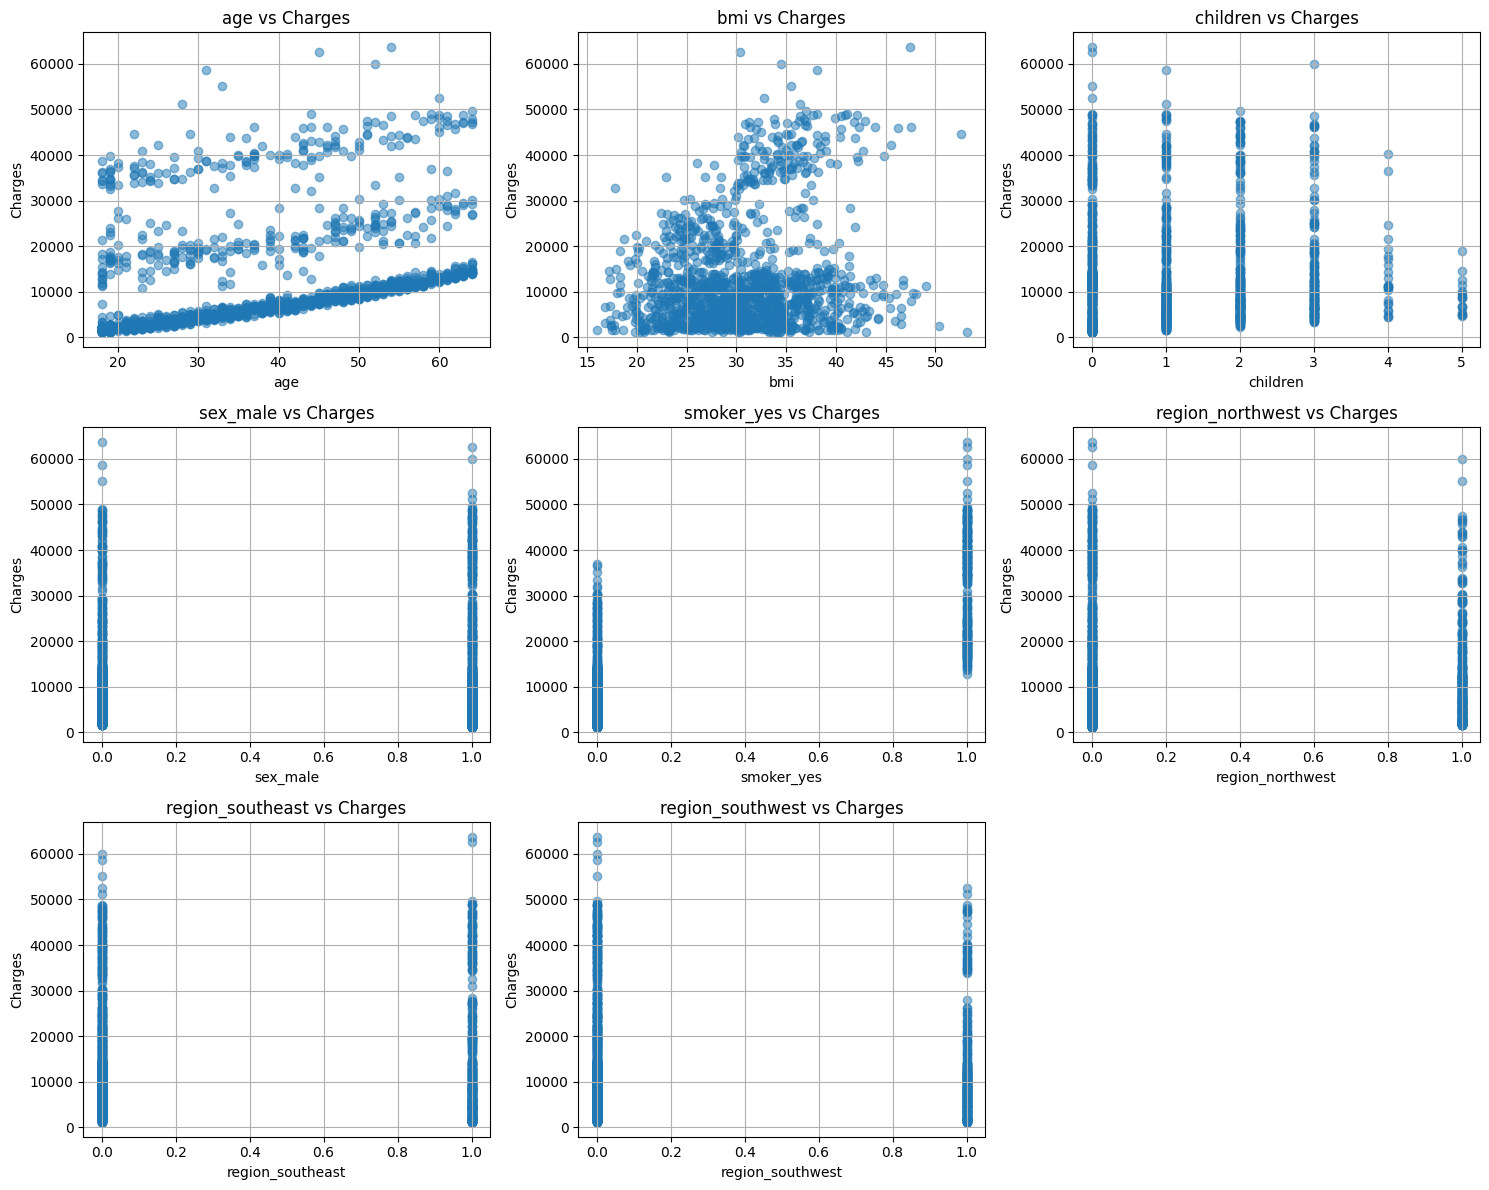

In [ ]:
df['charges_actual'] = np.exp(df['charges'])

features = ['age', 'bmi', 'children', 'sex_male', 'smoker_yes',
            'region_northwest', 'region_southeast', 'region_southwest']

n = len(features)
cols = 3
rows = (n + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(features):
    plt.subplot(rows, cols, i + 1)
    plt.scatter(df[feature], df['charges_actual'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("Charges")
    plt.title(f"{feature} vs Charges")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Ensure val_Y_true and val_Y_pred are numpy arrays
val_Y_true_np = val_Y_true.cpu().numpy() if isinstance(val_Y_true, torch.Tensor) else val_Y_true
val_Y_pred_np = val_Y_pred.cpu().numpy() if isinstance(val_Y_pred, torch.Tensor) else val_Y_pred

# Unscale the data by applying np.exp
val_Y_true_unscaled = np.exp(val_Y_true_np)
val_Y_pred_unscaled = np.exp(val_Y_pred_np)

# Recalculate MSE and MAE
mse_unscaled = mean_squared_error(val_Y_true_unscaled, val_Y_pred_unscaled)
mae_unscaled = mean_absolute_error(val_Y_true_unscaled, val_Y_pred_unscaled)

print("ANN Regression Evaluation (Unscaled Data):")
print(f"MSE (Unscaled): {mse_unscaled:.2f}")
print(f"MAE (Unscaled): {mae_unscaled:.2f}")

ANN Regression Evaluation (Unscaled Data):
MSE (Unscaled): 49966216.00
MAE (Unscaled): 3704.13
